In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from tensorflow.python.keras._impl.keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv('./cdn_memory_used.csv', usecols=[0,1,2], index_col=[0], parse_dates=[0])


In [3]:
dataset['2019-01-25 16:01:17']

,host,value
time,,
2019-01-25 16:01:17,fj3-cmcdn0.fjnd.cmcdn.net,5.31417


In [4]:
dataset = dataset.drop(dataset[dataset['host']=='fj3-cmcdn0.fjnd.cmcdn.net'].index, axis=0)
dataset = dataset.drop(dataset[dataset['host']=='gxdd2-cmcdn1.gxnn.cmcdn.net'].index, axis=0)


In [5]:
datasets = []
datasets.append(dataset[dataset['host']=='jswx01-cmcdn0.jswx.cmcdn.net'])
datasets.append(dataset[dataset['host']=='jswx04-cmcdn0.jswx.cmcdn.net'])
datasets.append(dataset[dataset['host']=='sc3-cmcdn3.scyd.cmcdn.net'])
datasets.append(dataset[dataset['host']=='zjwz-cmcdn8.wzyd.cmcdn.net'])
datasets.append(dataset[dataset['host']=='zjwz-cmcdn9.wzyd.cmcdn.net'])

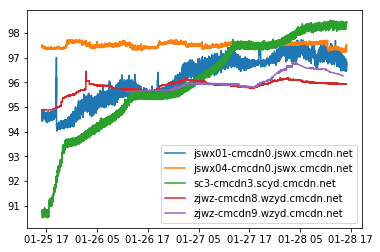

In [6]:
title = ['jswx01-cmcdn0.jswx.cmcdn.net', 'jswx04-cmcdn0.jswx.cmcdn.net', 'sc3-cmcdn3.scyd.cmcdn.net',
        'zjwz-cmcdn8.wzyd.cmcdn.net', 'zjwz-cmcdn9.wzyd.cmcdn.net']
for i in range(len(datasets)):
    plt.plot(datasets[i].value, label=title[i])
    plt.legend()
plt.show()

In [7]:
training_set = datasets[0].iloc[:, 1:2].values
training_set

array([[94.69783302],
       [94.42522675],
       [94.46262695],
       ...,
       [96.71681668],
       [96.844235  ],
       [96.71085205]])

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
training_set_scaled = scaler.fit_transform(training_set)

In [9]:
train_size = int(len(training_set) * 0.7)
test_size = len(training_set) - train_size
train, test = training_set[0:train_size], training_set[train_size:len(datasets[0])]

In [32]:
steps = 180
X_train = []
Y_train = []
for i in range(steps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-steps])
    Y_train.append(training_set_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [33]:
Y_train.shape, X_train.shape

((25734,), (25734, 1))

In [34]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [35]:
regressor = tf.keras.models.Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.Dense(units=1))

regressor.compile(loss='mean_squared_error', optimizer='Adam')

regressor.fit(X_train, Y_train, epochs=1, batch_size = 30)


Epoch 1/1
25734/25734 [==============================] - 7s 263us/step - loss: 0.0241


In [36]:
trainPredict = regressor.predict(X_train)
trainPredict

array([[0.19049677],
       [0.11667651],
       [0.12674664],
       ...,
       [0.71670926],
       [0.712508  ],
       [0.7441486 ]], dtype=float32)

In [37]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([Y_train])
trainPredict, trainY

(array([[94.73768 ],
        [94.45917 ],
        [94.497154],
        ...,
        [96.72298 ],
        [96.70712 ],
        [96.8265  ]], dtype=float32),
 array([[94.79820741, 94.70826204, 94.67134373, ..., 96.71681668,
         96.844235  , 96.71085205]]))

In [38]:
import math
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))



Train Score: 0.20 RMSE


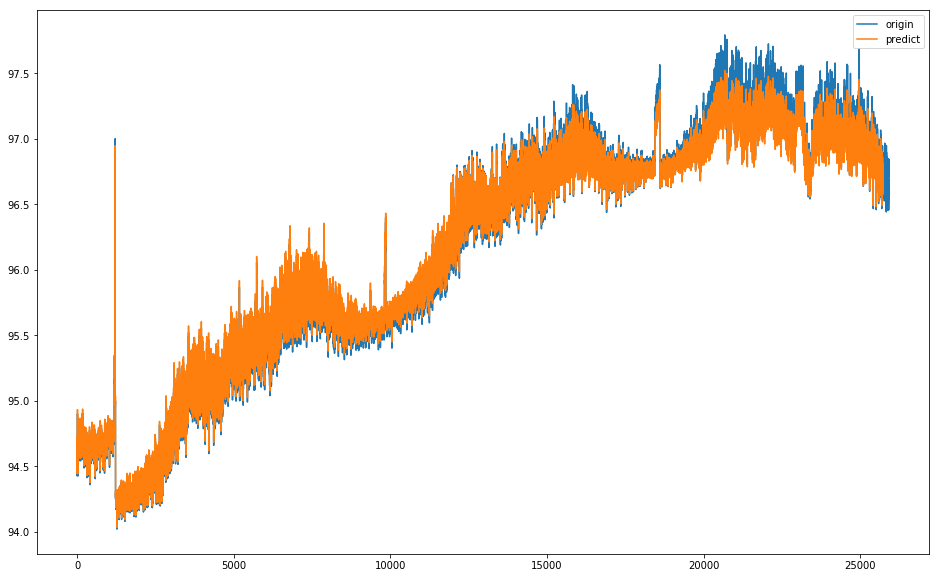

In [18]:
plt.figure(figsize=(16,10))
plt.plot(training_set, label = 'origin')
plt.plot(trainPredict, label = 'predict')
plt.legend()
plt.show()
